## Project 1
### Simple Object Detection with Faster R-CNN on the Pascal VOC or COCO Dataset

Reference From [Pytorch TorchVision Data](https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

### To Start
To start Please download the dataset from

If you use linux please use from
``` 
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
```

## Import

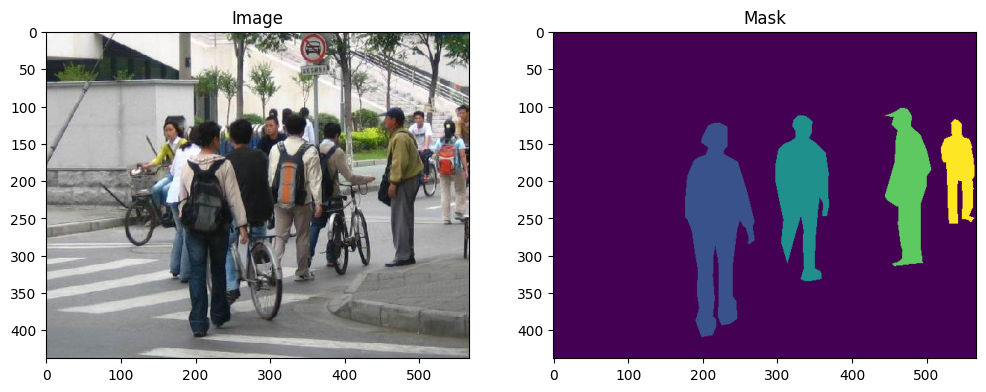

In [2]:
import matplotlib.pyplot as plt
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

image = read_image("pfd-dataset/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("pfd-dataset/PennFudanPed/PedMasks/FudanPed00046_mask.png")

# Display the Example Picture
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Image')

plt.imshow(image.permute(1,2,0))
plt.subplot(122)
plt.title('Mask')
plt.imshow(mask.permute(1,2,0))

Create the dataset class

In [3]:
# Create the set of dataset based on Pytorch Dataaset Based Class
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self,root,transforms):
        super().__init__()
        self.root = root
        self.transforms = transforms

        # Load all the image once init and sorting to ensure their aligned
        # Beacause it have both image and mask files
        self.imgs  = list(sorted(os.listdir(os.path.join(root,"PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root,'PedMasks'))))

    def __getitem__(self, idx):
        # Load Image and mask
        # Create full image path name joining between the folder and individual image path
        img_path = os.path.join(self.root,"PNGImages",self.imgs[idx])
        mask_path = os.path.join(self.root,"PedMasks",self.masks[idx])

        # Get Image and Path
        img = read_image(img_path)
        mask  = read_image(mask_path)

        # Every instance in mask encode with different color
        obj_ids = torch.unique(mask)

        # First Id of them is the background so remove them
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # Split the color-encoded mask into a set of binary mask
        # Find the correct mask
        masks = mask == obj_ids[:,None,None]
        masks = masks.to(dtype=torch.uint8)

        # Get bounding box coordinates for each mask
        boxes = masks_to_boxes(mask)

        # In each Image have only one class
        # Get labels from class
        labels = torch.ones((num_objs),dtype=torch.int64)

        # Assign Image ID
        image_id = idx
        # Find the area
        area = (boxes[:,-3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])

        # Suppose that all of object inside is not crowd or no-overlap
        iscrowd = torch.zeros((num_objs),dtype=torch.int64)

        # Convert to torch vision (tv) tensor
        img = tv_tensors.Image(img)

        # Define variable taget and attach it's meta data like
        # Bounding boxes, mask, labels, image id, area, isCrowd
        target = {}
        # Get from the bounding box function,
        target['boxes'] = tv_tensors.BoundingBoxes(boxes,format="XYXY",canvas_size=F.get_size(img)) 
        target['masks'] = tv_tensors.Mask(masks)
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img,target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)


## Define the Model
We will define Mask-R-CNN is based on Faster-R-CNN. It predicts both bounding boxes and class scores fro objects in image.

Find the regison of interest (ROI) and Projection the Region of Interest into Convolutional Feature Map before go to pooling layer and coming to the fully connected networks.
And then split into 2 outputs for reach region of interest. One will be enter the softmax activation function and get output and another one will enter the bbox regressor to get the bounding box.

Mask R-CNN add the extra into Fast R-CNN which predict the segmentation masks for each instance.


### Findtunning from a pretrained model
Start from a pretrained model from COCO dataset which is Common Objects in Context. It's commonly used for benchmarking computer vision models.

We will use the FasterRCNN ResNet50 which created to solved the vanishing and exploding gradient problems.
They used the technique name **skip connections** which is skipping some layers in between.
In this network they introduced the Residual Block, Resnets are made by stacking these residual blocks together.

In the very deep network, it can make the model training faster and avoids problem like gradient being too small (vanishing graident problem)


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load  the pre-trained model on COCO dataset
model = torchvision.models.detection.faster_rcnn.fasterrcnn_resnet50_fpn(weights="DEFAULT")

0.1%

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\theet/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100.0%


Replace the classifier with a new one that has user defined **num_classes** which is will be 2 which are person and background.

In [5]:
num_classes = 2

# Get the Number of Input Features for the original model classifier
in_fatures = model.roi_heads.box_predictor.cls_score.in_features

# Replace the Pretrain model head with a new one for us
model.roi_heads.box_predictor = FastRCNNPredictor(in_fatures,num_classes)

## Object Detection and Instance segmentation

We need to compute the instance segmentation masks using Mask R-CNN.

In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load the instance segmentaion pre-trained model in COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get Number of Input Features for the classifier
    in_fatures = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained model head with the new number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_fatures,num_classes)

    # Get the Number of Input Features for mask classification
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the Mask predictor with the new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

Get the Engine, Utility, and Transform function from the reference.

In [8]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Create a helper function which is to get the transform

In [ ]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transform = []

    if train:
        transform.append(T.RandomHorizontalFlip(0.5))
    
    transform.append(T.ToDtype(torch.float,scale= True))
    transform.append(T.ToPureTensor())
    return T.Compose(transform)